# ABIDE subtype prototype
This is a notebook to set up the framework to conduct the large scale subtype analysis I plan with ABIDE. The goal for this notebook is to:

- create functions to deal with recurring tasks
- parallelize computation heavy and memory moderate tasks
- visualize and save the average subtype maps on disk

Specific to this project are these steps:

1. build similarity matrix of subjects based on individual network maps (scores, seed, dual regression)
2. cluster similarity matrix into 7 subgroups
3. compute the average cluster maps, also __subtypes__
4. generate individual weights for each subtype by computing the spatial correlation of individual maps with the subtype
5. run a GLM with the factors of site, motion and some diagnostic categories.
6. Investigate the individual factors with post-hoc contrasts and plot the results
7. Compare the model solutions of different network maps
8. Save the subtype maps as nifti objects and display them

In [45]:
# Imports
import os
import glob
import numpy as np
import pandas as pd
import nibabel as nib
import brainbox as bb
import statsmodels.api as sm
from scipy import stats as st
from matplotlib import gridspec
from scipy import cluster as scl
from nilearn import plotting as nlp
from matplotlib import pyplot as plt
from sklearn import linear_model as slin

In [46]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [47]:
def get_mask(mask_path):
    """
    Get the mask
    """
    m_img = nib.load(mask_path)
    mask = m_img.get_data()
    mask = mask!=0

    return mask, m_img

In [19]:
def prep_pheno(pheno_path, data_path, map_type, template):
    """
    Remove entries with duplicates or no imaging files
    """
    pheno = pd.read_csv(pheno_path)
    drop_id = list()
    path_list = list()
    pheno = pd.read_csv(pheno_path)
    for index, row in pheno.iterrows():
        s_id = row['SUB_ID']
        s_path = glob.glob(os.path.join(data_path, map_type, template.format(s_id, map_type)))
        if s_path:
            path_list.append(s_path[0])
        else:
            drop_id.append(index)
            continue
    clean_pheno = pheno.drop(drop_id)
    
    return clean_pheno, path_list

In [21]:
def get_files(paths, mask):
    """
    Get files from a list of paths and store the masked
    time series in an array and demean it
    """
    n_vox = np.sum(mask)
    n_files = len(path_list)
    # Prepare the storage matrix
    net_mat = np.zeros((n_vox, n_files))
    # Go through the files
    for index, s_path in enumerate(path_list):
        f_net = nib.load(s_path).get_data()[mask][..., net_id]
        net_mat[..., index] = f_net
    net_mat = net_mat - np.mean(net_mat,0)
    
    return net_mat

In [17]:
def make_corr(net_mat):
    """
    Build a subject by subject correlation matrix
    from the spatial maps and use hierarchical clustering
    to find a subtype partition
    """
    # Make a correlation matrix of the subjects
    corr_sub = np.corrcoef(net_mat, rowvar=0)
    link_sub = scl.hierarchy.linkage(corr_sub, method='ward')
    part_sub = scl.hierarchy.fcluster(link_sub, subtypes, criterion='maxclust')
    
    return (corr_sub, link_sub, part_sub)

In [39]:
def prep_glm(pheno, net_mat, part_sub):
    """
    Prepare a glm
    """
    n_vox = net_mat.shape[0]
    n_files = net_mat.shape[1]
    subtypes = len(np.unique(part_sub))
    # Make the average of the subtypes
    sbt_avg = np.zeros((n_vox, subtypes))
    for idx in range(subtypes):
        sub_id = np.unique(part_sub)[idx]
        sbt_avg[..., idx] = np.mean(net_mat[...,part_sub==sub_id],1)
    
    # Generate the individual weights
    weights = np.zeros((n_files, subtypes))
    for s_id in range(subtypes):
        type_map = sbt_avg[:, s_id]
        weights[:, s_id] = np.array([np.corrcoef(type_map, net_mat[:,x])[0,1] for x in range(n_files)])
    
    # Generate the model matrix
    factors = ['DX_GROUP', 'AGE_AT_SCAN', 'FD_scrubbed']
    # Make dummy variables for the site factor
    site_factor = pd.get_dummies(pheno['SITE_ID'])
    # Turn the first site into the intercept
    site_factor = site_factor.rename(columns={site_factor.keys()[0]: 'INTERCEPT'})
    site_factor['INTERCEPT'] = 1
    # Get the other variables
    other_factors = pheno.ix[:,factors]
    # Turn diagnosis into [0,1] vector
    other_factors['DX_GROUP'] = other_factors['DX_GROUP'].values - 1
    # Demean age
    other_factors['AGE_AT_SCAN'] = other_factors['AGE_AT_SCAN']-np.mean(other_factors['AGE_AT_SCAN'].values)
    # Put them back together
    glm_pheno = pd.concat([site_factor, other_factors], axis=1)
    
    return (weights, glm_pheno, sbt_avg)

In [9]:
def visu_net(corr_sub, link_sub):
    """
    Show the correlation map and the hierarchical clustering
    to get an idea of the data structure
    """
    f = plt.figure(figsize=(8,10))
    ax = f.add_subplot(111)
    subdend = bb.visu.add_subplot_axes(ax, [0, 0.71, 1, 0.29])
    submat = bb.visu.add_subplot_axes(ax, [0, 0, 1, 0.7])
    Z1 = scl.hierarchy.dendrogram(link_sub, ax=subdend, color_threshold=6)
    idx = Z1['leaves']
    tmp = corr_sub[idx, :]
    show_corr = tmp[:, idx]
    submat.matshow(show_corr, aspect='auto')
    subdend.set_xticklabels([])
    submat.set_xticklabels([])
    submat.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

In [36]:
def visu_weights(weights, part_sub):
    """
    Show the weights of each subtype
    """
    subtypes = len(np.unique(part_sub))
    # Show the weights by subtype
    fig = plt.figure(figsize=(12,3))
    gs = gridspec.GridSpec(1, subtypes, wspace=0.3)
    for i, stp in enumerate(np.unique(part_sub)):
        ax = fig.add_subplot(gs[0,i])
        ax.set_ylim([0.3, 1])
        ax.set_xticklabels([])
        # Take a subsample of the data, fitting the current subtype
        stp_data = weights[part_sub==stp,:]
        tmp = ax.violinplot(stp_data)
        ax.set_title('subjects subtype {}'.format(i+1))

In [43]:
def visu_covar(clean_pheno, part_sub):
    """
    Show some covariates
    """
    # Do one more run, but look at motion
    fig = plt.figure(figsize=(12,3))
    gs = gridspec.GridSpec(1, subtypes, wspace=0.3)
    ages = [clean_pheno.loc[part_sub==stp]['AGE_AT_SCAN'].values for stp in np.unique(part_sub)]
    frames = [clean_pheno.loc[part_sub==stp]['frames_scrubbed '].values for stp in np.unique(part_sub)]
    motion = [clean_pheno.loc[part_sub==stp]['FD_scrubbed'].values for stp in np.unique(part_sub)]
    # Age
    ax_age = fig.add_subplot(gs[0,0])
    ax_age.set_xticklabels([])
    tmp = ax_age.violinplot(ages)
    ax_age.set_title('Age')
    # Age
    ax_frame = fig.add_subplot(gs[0,1])
    ax_frame.set_xticklabels([])
    tmp = ax_frame.violinplot(frames)
    ax_frame.set_title('Scrubbed Frames')
    # Age
    ax_motion = fig.add_subplot(gs[0,2])
    ax_motion.set_xticklabels([])
    tmp = ax_motion.violinplot(motion)
    ax_motion.set_title('Scrubbed FD')

In [98]:
def visu_subtype(subtype_map, mask_path, threshold=0.3, figsz=(10,8)):
    """
    Show the subtype maps
    """
    # Load the mask again to get the image
    mask, mask_image = get_mask(mask_path)
    # Get the subtypes out
    n_sbt = subtype_map.shape[1]
    # Prepare the figure
    fig = plt.figure(figsize=figsz)
    gs = gridspec.GridSpec(n_sbt, 1, hspace=0.3)
    for s_id in range(n_sbt):
        sbt_map = subtype_map[:, s_id]
        # Remap the map into volume space
        template = np.zeros_like(mask, dtype=np.float64)
        template[mask] = sbt_map
        # Make a nifti image out of the volume
        nifti_vol = nib.Nifti1Image(template, affine=mask_image.get_affine(), header=mask_image.get_header())
        # Visualize the thing with nilearn
        ax = fig.add_subplot(gs[s_id,0])
        nlp.plot_glass_brain(nifti_vol, title='subtype {}'.format(s_id+1),axes=ax, cmap=cm.spring, threshold=threshold)

In [13]:
def run_glm(weights, glm_pheno, subtype=0):
    """
    Run the GLM
    """
    model = sm.OLS(weights[:,subtype], glm_pheno)
    results = model.fit()
    print(results.summary())
    return results

In [15]:
# Paths
subtypes = 4
scale = 7
network = 2
net_id = network - 1
template = '*_fmri_{:07d}_session_1_run1_{}.nii.gz'
data_path = '/data1/abide/Out/Scores/sc{:02d}/time'.format(scale)
pheno_path = '/data1/abide/Pheno/unconstrained_3box_189_sample.csv'
mask_path = '/data1/abide/Mask/mask_data_specific.nii.gz'
map_types = ['stability_maps', 'rmap_part', 'dual_regression']
map_type = map_types[1]

In [31]:
# Prepare the data
# Get the mask
mask = get_mask(mask_path)
# Get nonduplicate paths
(clean_pheno, path_list) = prep_pheno(pheno_path, data_path, map_type, template)
# Load the requested files
net_mat = get_files(path_list, mask)
# Build the correlation matrix
(corr_sub, link_sub, part_sub) = make_corr(net_mat)
# Get the weights and the GLM model matrix
(weights, glm_pheno, subtype_map) = prep_glm(clean_pheno, net_mat, part_sub)

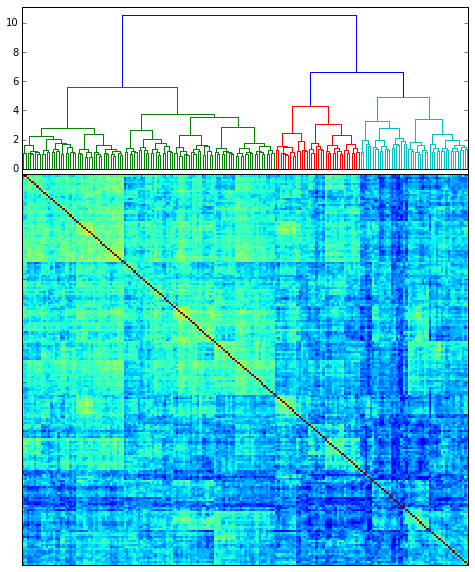

In [33]:
# Visualize the sample
visu_net(corr_sub, link_sub)

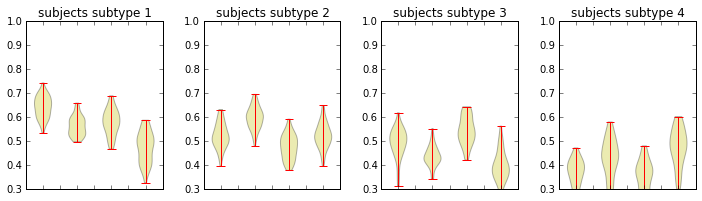

In [37]:
visu_weights(weights, part_sub)

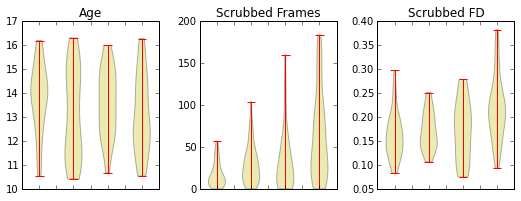

In [38]:
visu_covar(clean_pheno, part_sub)

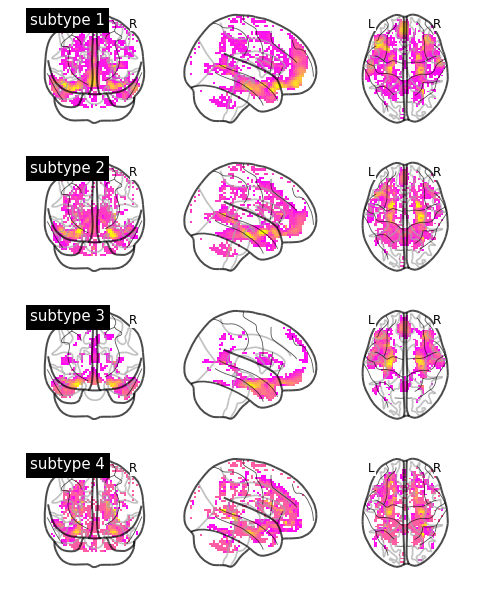

In [105]:
visu_subtype(subtype_map, mask_path, threshold=0.2, figsz=(8,10))

In [116]:
# Get the number of sites
n_sites = len(clean_pheno['SITE_ID'].unique())
# Prepare GLM contrasts
con_vec = np.zeros((2,glm_pheno.shape[1]))
# Diagnosis vs site
con_vec[0,1:n_sites] = 1
con_vec[0,n_sites] = -1*(n_sites-1)
# Diagnosis vs motion
con_vec[1,-1] = 1
con_vec[1,n_sites] = -1

In [117]:
con_vec

array([[ 0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -9.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  1.]])

In [118]:
# Run a GLM
glm_sbt1 = run_glm(weights, glm_pheno, subtype=0)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.384
Model:                            OLS   Adj. R-squared:                  0.342
Method:                 Least Squares   F-statistic:                     9.142
Date:                Mon, 13 Jul 2015   Prob (F-statistic):           1.45e-13
Time:                        13:08:54   Log-Likelihood:                 185.19
No. Observations:                 189   AIC:                            -344.4
Df Residuals:                     176   BIC:                            -302.2
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT       0.7533      0.038     19.699      

In [119]:
# Post Hoc Tests
glm_sbt1.t_test(con_vec)

<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
c0            -1.0365      0.274     -3.785      0.000        -1.577    -0.496
c1            -0.9592      0.137     -7.021      0.000        -1.229    -0.690

In [120]:
glm_sbt2 = run_glm(weights, glm_pheno, subtype=1)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.404
Model:                            OLS   Adj. R-squared:                  0.363
Method:                 Least Squares   F-statistic:                     9.930
Date:                Mon, 13 Jul 2015   Prob (F-statistic):           1.06e-14
Time:                        13:09:25   Log-Likelihood:                 222.61
No. Observations:                 189   AIC:                            -419.2
Df Residuals:                     176   BIC:                            -377.1
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT       0.6520      0.031     20.782      

In [121]:
# Post Hoc Tests
glm_sbt2.t_test(con_vec)

<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
c0            -0.4167      0.225     -1.855      0.065        -0.860     0.027
c1            -0.7307      0.112     -6.519      0.000        -0.952    -0.510

In [122]:
glm_sbt3 = run_glm(weights, glm_pheno, subtype=2)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.352
Model:                            OLS   Adj. R-squared:                  0.307
Method:                 Least Squares   F-statistic:                     7.955
Date:                Mon, 13 Jul 2015   Prob (F-statistic):           8.56e-12
Time:                        13:09:34   Log-Likelihood:                 201.55
No. Observations:                 189   AIC:                            -377.1
Df Residuals:                     176   BIC:                            -334.9
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT       0.7337      0.035     20.918      

In [123]:
# Post Hoc Tests
glm_sbt3.t_test(con_vec)

<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
c0            -1.0965      0.251     -4.366      0.000        -1.592    -0.601
c1            -0.8306      0.125     -6.628      0.000        -1.078    -0.583

In [124]:
glm_sbt4 = run_glm(weights, glm_pheno, subtype=3)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     2.108
Date:                Mon, 13 Jul 2015   Prob (F-statistic):             0.0186
Time:                        13:09:40   Log-Likelihood:                 227.51
No. Observations:                 189   AIC:                            -429.0
Df Residuals:                     176   BIC:                            -386.9
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT       0.5355      0.031     17.515      

In [125]:
# Post Hoc Tests
glm_sbt4.t_test(con_vec)

<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
c0            -0.4727      0.219     -2.159      0.032        -0.905    -0.041
c1            -0.2280      0.109     -2.087      0.038        -0.444    -0.012